# 기계가 읽을 수 있나요?
---

## Google API 사용 테스트

In [1]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [2]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/01_Exploration/E18/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
path = os.getenv('HOME')+'/aiffel/01_Exploration/E18/ocr_python/test_img.jpg'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

total 1444
-rw-r--r--  1 root root 1466188 Sep 20 14:36 '[E-18][Node]문자를_읽을수있는_딥러닝.ipynb'
drwxr-xr-x  3 root root    4096 Sep 20 12:47  ocr_python
drwxr-xr-x 11 root root    4096 Sep 21 05:56  pjt_img
drwxr-xr-x  2 root root    4096 Sep 20 12:25  test_image
Texts:

"어머니, 어머니
우리 어머니.
바둑아, 바둑아
이리와.
나하고 놀자.
영이야, 놀자.
철수야, 가자.
1새 교실
|3의 41.
비
배을 |가지고
"

"어머니"

","

"어머니"

"우리"

"어머니"

"."

"바둑"

"아"

","

"바둑"

"아"

"이리"

"와"

"."

"나"

"하고"

"놀자"

"."

"영"

"이야"

","

"놀자"

"."

"철수"

"야"

","

"가자"

"."

"1"

"새"

"교실"

"|"

"3"

"의"

"41"

"."

"비"

"배을"

"|"

"가지고"
bounds: (346,220),(388,221),(387,243),(345,242)


# keras-ocr 써보기
---

In [3]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [4]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/j9JoYpaJH3A',
  'https://source.unsplash.com/eBkEJ9cH5b4'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

print(prediction_groups)

[[[('up', array([[381.9357 , 136.4266 ],
       [464.65897, 134.35852],
       [466.03934, 189.574  ],
       [383.31607, 191.64209]], dtype=float32)), ('wake', array([[ 65.16567, 136.59764],
       [247.32892, 138.43767],
       [246.7922 , 191.57365],
       [ 64.62896, 189.73363]], dtype=float32)), ('me', array([[267.1673 , 138.52963],
       [362.58685, 136.40918],
       [363.77197, 189.7384 ],
       [268.35242, 191.85886]], dtype=float32)), ('wheni', array([[ 68.2641 , 224.15443],
       [341.6715 , 228.71121],
       [340.58597, 293.84314],
       [ 67.17856, 289.28635]], dtype=float32)), ('im', array([[335., 225.],
       [461., 225.],
       [461., 293.],
       [335., 293.]], dtype=float32)), ('famous', array([[ 58.613846, 326.0107  ],
       [474.8542  , 333.3132  ],
       [473.39386 , 416.55075 ],
       [ 57.15352 , 409.24826 ]], dtype=float32))]], [[('8624', array([[ 97.69981 ,  18.878628],
       [509.74692 ,  16.675137],
       [510.29044 , 118.30859 ],
       [ 98.24

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


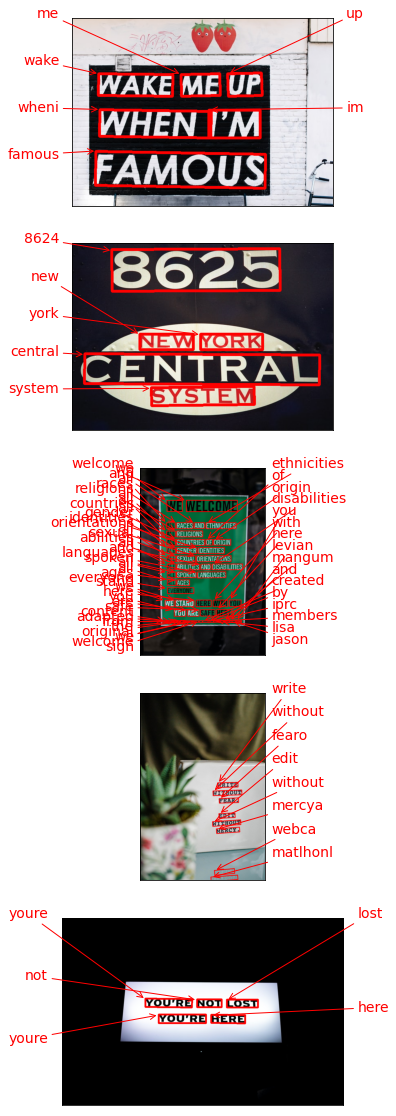

In [5]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

# 테서랙트 써보기
---

## 테서랙트로 문자 검출하고 이미지 자르기(detection)

crop_word_regions() 함수는 여러분이 선택한 테스트 이미지를 받아서, 문자 검출을 진행한 후, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴하는 함수이다.

In [7]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/01_Exploration/E18/ocr_python'
img_file_path = work_dir + '/test_img.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/01_Exploration/E18/ocr_python/0000.png
/aiffel/aiffel/01_Exploration/E18/ocr_python/0001.png
/aiffel/aiffel/01_Exploration/E18/ocr_python/0002.png
/aiffel/aiffel/01_Exploration/E18/ocr_python/0003.png
/aiffel/aiffel/01_Exploration/E18/ocr_python/0004.png
/aiffel/aiffel/01_Exploration/E18/ocr_python/0005.png
/aiffel/aiffel/01_Exploration/E18/ocr_python/0006.png
/aiffel/aiffel/01_Exploration/E18/ocr_python/0007.png
/aiffel/aiffel/01_Exploration/E18/ocr_python/0008.png
/aiffel/aiffel/01_Exploration/E18/ocr_python/0009.png
/aiffel/aiffel/01_Exploration/E18/ocr_python/0010.png
/aiffel/aiffel/01_Exploration/E18/ocr_python/0011.png
/aiffel/aiffel/01_Exploration/E18/ocr_python/0012.png
/aiffel/aiffel/01_Exploration/E18/ocr_python/0013.png
/aiffel/aiffel/01_Exploration/E18/ocr_python/0014.png
/aiffel/aiffel/01_Exploration/E18/ocr_python/0015.png
/aiffel/aiffel/01_Exploration/E18/ocr_python/0016.png


## 테서랙트로 잘린 이미지에서 단어 인식하기

 검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 영역별 텍스트가 결괏값으로 나오는 image_to_string()를 사용하게 된다.

In [8]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

o} HL]

O41 LU

2 2

OF} 14 L]

Hp Of

4}

O |

O |

Z|

ot

L}+ of 4

= AL

oJ 0] OF

= AL

A} =~ OF

TEAS.

Z 2c

Done


# 프로젝트 : 다양한 OCR 모델 비교하기
---

## Step0. OCR을 활용한 서비스 기획

1. 서비스 이름 : 간판 글씨 인식하여 텍스트 추출
2. 서비스 목적 : 
    * 간판을 웹에 검색하고 싶은데 직접 치기 귀찮(?)거나 영문 간판이 아닌 다른 외국어일 경우 해당 외국어가 모바일 키보드에 존재하지 않을 경우 유용하다.(pretrained 된 모델이 영문이라 테스트는 영문으로 수행)
3. 서비스 내용 : 
    1. 간판을 모바일로 촬영 후 해당 이미지에서 텍스트가 있는 위치를 인식
    2. 인식된 텍스트를 분석하여 텍스트로 추출

## Step1. 검증용 데이터셋 준비

OCR 관련해서 오늘 다루어본 주제는 텍스트의 모양과 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미치는 요인들에 관한 것이었습니다. 여러분들은 위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 이미지 데이터를 모아야 합니다. 이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요합니다.

가능하다면 함께 학습하는 동료들과 힘을 합쳐보는 것을 추천합니다. 그렇다고 너무 많은 이미지 데이터로 검증하는 것은 이후 결과를 정리하는 것이 힘들 수 있으니 테스트용 이미지는 아무리 많아도 20장을 넘기지 않는 것으로 합시다.

### Test Image 확인

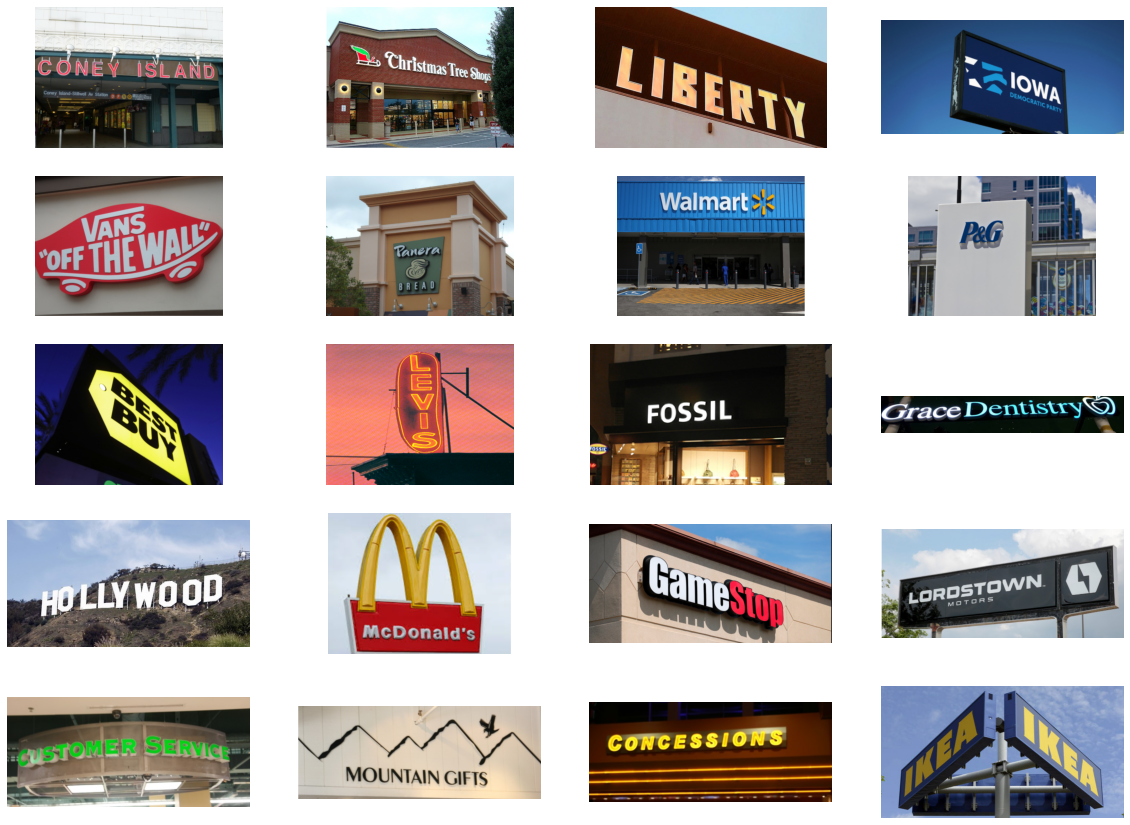

In [41]:
import matplotlib.pyplot as plt
from PIL import Image 
%matplotlib inline

IMG_CNT = 20
test_img_path = os.getenv('HOME')+'/aiffel/01_Exploration/E18/pjt_img/'
test_img_list = [test_img_path + f'test{i+1}.png' for i in range(0, IMG_CNT)]
plt.figure(figsize=(20, 15))

for i, img in enumerate(test_img_list):
    temp_img = Image.open(img)
    plt.subplot(5,4,i+1)
    plt.axis('off')
    plt.imshow(temp_img)
    

plt.show()

## Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

위 3가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보셨을 것입니다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다.

### 2-1. Google OCR API

In [42]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/01_Exploration/E18/ocr_python/my_google_api_key.json'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for img in test_img_list:
    detect_text(img)
    print('-'*20, img,'-'*20)

Texts:

"CONEY ISLAND
Coney Island-Stillwell Av Station DFNO
"

"CONEY"

"ISLAND"

"Coney"

"Island-Stillwell"

"Av"

"Station"

"DFNO"
bounds: (326,369),(412,373),(411,391),(325,387)
-------------------- /aiffel/aiffel/01_Exploration/E18/pjt_img/test1.png --------------------
Texts:

"Christmas Tree Shogs
STOP
TOR
PEDESTRAN
"

"Christmas"

"Tree"

"Shogs"

"STOP"

"TOR"

"PEDESTRAN"
bounds: (699,518),(738,517),(738,527),(699,528)
-------------------- /aiffel/aiffel/01_Exploration/E18/pjt_img/test2.png --------------------
Texts:

"LIBERTY
"

"LIBERTY"
bounds: (74,109),(595,261),(565,364),(44,212)
-------------------- /aiffel/aiffel/01_Exploration/E18/pjt_img/test3.png --------------------
Texts:

"IOWA
DEMOCRATIC PARTY
"

"IOWA"

"DEMOCRATIC"

"PARTY"
bounds: (363,180),(396,191),(391,206),(358,195)
-------------------- /aiffel/aiffel/01_Exploration/E18/pjt_img/test4.png --------------------
Texts:

"VANS
"OFF THE WALL
"

"VANS"

""OFF"

"THE"

"WALL"
bounds: (444,231),(693,189),(719,3

### 2-2. keras-ocr

In [43]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [44]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 

images = [ keras_ocr.tools.read(url) for url in test_img_list]
prediction_groups = [pipeline.recognize([url]) for url in test_img_list]

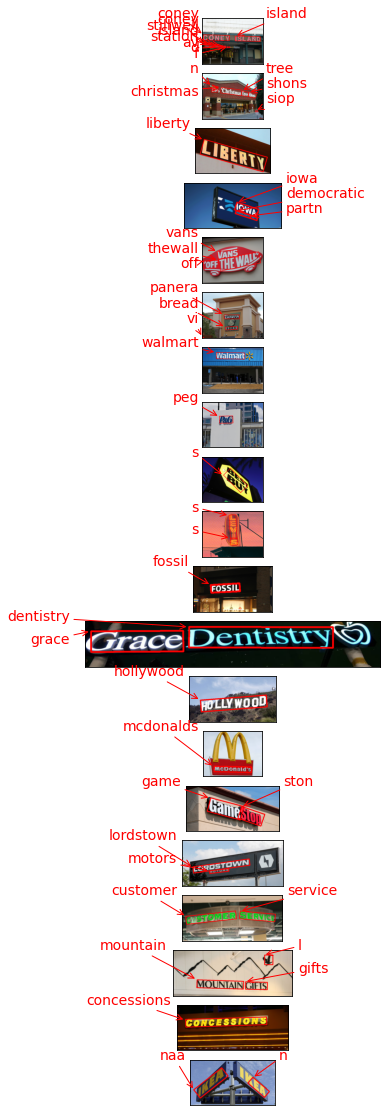

In [68]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

In [77]:
for i in range(0, IMG_CNT):
    for j in prediction_groups[i][0]:
        print(j[0])
    print('-'*20, f'IMG {i+1} Done', '-'*20)

coney
island
coney
island
stillwell
av
station
d
f
-------------------- IMG 1 Done --------------------
n
christmas
tree
shons
siop
-------------------- IMG 2 Done --------------------
liberty
-------------------- IMG 3 Done --------------------
iowa
democratic
partn
-------------------- IMG 4 Done --------------------
vans
thewall
off
-------------------- IMG 5 Done --------------------
panera
bread
vi
-------------------- IMG 6 Done --------------------
walmart
-------------------- IMG 7 Done --------------------
peg
-------------------- IMG 8 Done --------------------
s
-------------------- IMG 9 Done --------------------
s
s
-------------------- IMG 10 Done --------------------
fossil
-------------------- IMG 11 Done --------------------
dentistry
grace
-------------------- IMG 12 Done --------------------
hollywood
-------------------- IMG 13 Done --------------------
mcdonalds
-------------------- IMG 14 Done --------------------
game
ston
-------------------- IMG 15 Done -------

### 2-3. Tesseract

In [46]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [47]:
for i, img in enumerate(test_img_list):
    cropped_image_path_list = crop_word_regions(img, os.getenv('HOME')+f'/aiffel/01_Exploration/E18/pjt_img/crop{i+1}')
    recognize_images(cropped_image_path_list)
    print('-'*20, img, '-'*20)

# Test 용    
# img =  '/aiffel/aiffel/01_Exploration/E18/pjt_img/test3.png'
# cropped_image_path_list = crop_word_regions(img, os.getenv('HOME')+f'/aiffel/01_Exploration/E18/pjt_img/crop1')
# recognize_images(cropped_image_path_list)
# print('-'*20, img, '-'*20)

/aiffel/aiffel/01_Exploration/E18/pjt_img/crop1/0000.png
-

Done
-------------------- /aiffel/aiffel/01_Exploration/E18/pjt_img/test1.png --------------------
/aiffel/aiffel/01_Exploration/E18/pjt_img/crop2/0000.png
/aiffel/aiffel/01_Exploration/E18/pjt_img/crop2/0001.png

Nee eee ee ee ee eee =. ree Eee —eoeoaaaoooooaooooaooEoEoEoEeEeEeEEoEeEeEeEeeeeEeEeEeEeeEeEeEeEeEeEeEeEeEeEeEeEeEeEeEeEeEeEeEeEeEeEeEeEeEeEeEeEeEeEe——eeeaeEeEeEeEeEeEeEeEeEeeEeEeEeEeEeEeEeEeEeeE——eeee eee en ee ee eee

Done
-------------------- /aiffel/aiffel/01_Exploration/E18/pjt_img/test2.png --------------------
/aiffel/aiffel/01_Exploration/E18/pjt_img/crop3/0000.png
Su \a

Done
-------------------- /aiffel/aiffel/01_Exploration/E18/pjt_img/test3.png --------------------
/aiffel/aiffel/01_Exploration/E18/pjt_img/crop4/0000.png
/aiffel/aiffel/01_Exploration/E18/pjt_img/crop4/0001.png
/aiffel/aiffel/01_Exploration/E18/pjt_img/crop4/0002.png
5

bs

se

Done
-------------------- /aiffel/aiffel/01_Exploration/

## Step3. 테스트 결과 정리

모듈들마다 출력 형태가 다릅니다. 분석을 위해 결과를 일목요연하게 정리해 보는 것이 도움이 될 것입니다. 시각화 방법이 함께 활용된다면 더욱 좋겠군요.

<table>
    <tr>
        <td>이미지 번호</td>
        <td>OCR 알고리즘</td>
        <td >기댓값</td>
        <td>실제 출력값</td>
    </tr>
    <tr>
        <td>1</td>
        <td>Google api</td>
        <td>CONEY ISLAND Coney Island-Stillwell Av Station DFNQ</td>
        <td>"CONEY ISLAND" "Coney Island-Stillwell Av Station DFNO"</td>
    </tr>
    <tr>
        <td></td>
        <td>keras-ocr</td>
        <td ></td>
        <td>"coney" "island" "coney" "island" "stillwell" "av" "station" "d" "f"<td>
    </tr>
    <tr>
        <td></td>
        <td>Tesseract</td>
        <td ></td>
        <td>"-"<td>
    </tr>
    <tr>
        <td>2</td>
        <td>Google api</td>
        <td>Christmas Tree Shops</td>
        <td>"Christmas Tree Shogs" "STOP" "TOR" "PEDESTRAN"<td>
    </tr>
    <tr>
        <td></td>
        <td>keras-ocr</td>
        <td></td>
        <td>"n" "christmas" "tree" "shons" "siop"<td>
    </tr>
    <tr>
        <td></td>
        <td>Tesseract</td>
        <td></td>
        <td>"Nee eee ee ee ee eee =. ree Eee —eoeoaaaoooooaooooaooEoEoEoEeEeEeEEo"<td>
    </tr>
    <tr>
        <td>3</td>
        <td>Google api</td>
        <td>LIBERTY</td>
        <td>"LIBERTY"<td>
    </tr>
    <tr>
        <td></td>
        <td>keras-ocr</td>
        <td></td>
        <td>"liberty"<td>
    </tr>
    <tr>
        <td></td>
        <td>Tesseract</td>
        <td></td>
        <td>"Su \a"<td>
    </tr>
    <tr>
        <td>4</td>
        <td>Google api</td>
        <td>"IOWA" "DEMOCRATIC PARTY"</td>
        <td>"IOWA" "DEMOCRATIC" "PARTY"<td>
    </tr>
    <tr>
        <td></td>
        <td>keras-ocr</td>
        <td></td>
        <td>"iowa" "democratic" "partn"<td>
    </tr>
    <tr>
        <td></td>
        <td>Tesseract</td>
        <td></td>
        <td>"t" "bs" "se"<td>
    </tr>  
    <tr>
        <td>5</td>
        <td>Google api</td>
        <td>"VANS OFF THE WALL"</td>
        <td>"VANS" "OFF" "THE" "WALL"<td>
    </tr>
    <tr>
        <td></td>
        <td>keras-ocr</td>
        <td></td>
        <td>"vans" "thewall" "off"<td>
    </tr>
    <tr>
        <td></td>
        <td>Tesseract</td>
        <td></td>
        <td>NAN<td>
    </tr>
    <tr>
        <td>6</td>
        <td>Google api</td>
        <td>"Panera" "BREAD"</td>
        <td>"Panera" "BREAD"<td>
    </tr>
    <tr>
        <td></td>
        <td>keras-ocr</td>
        <td></td>
        <td>"panera" "bread" "vi"<td>
    </tr>
    <tr>
        <td></td>
        <td>Tesseract</td>
        <td></td>
        <td>"sa y"<td>
    </tr>
    <tr>
        <td>7</td>
        <td>Google api</td>
        <td>"Walmart"</td>
        <td>"Walmart" "SZAI" "ZAL"<td>
    </tr>
    <tr>
        <td></td>
        <td>keras-ocr</td>
        <td></td>
        <td>"walmart"<td>
    </tr>
    <tr>
        <td></td>
        <td>Tesseract</td>
        <td></td>
        <td>"1am aaa aaa aaa aaa aa aa «S(T a a LL maaaaaamamaammaaam" "--" "Walmart" "he" "= SRE |"<td>
    </tr>
    <tr>
        <td>8</td>
        <td>Google api</td>
        <td>"P&G"</td>
        <td>"PeG"<td>
    </tr>
    <tr>
        <td></td>
        <td>keras-ocr</td>
        <td></td>
        <td>"peg"<td>
    </tr>
    <tr>
        <td></td>
        <td>Tesseract</td>
        <td></td>
        <td>";"<td>
    </tr>
    <tr>
        <td>9</td>
        <td>Google api</td>
        <td>"BEST" "BUY"</td>
        <td>"PEF" "BEST" "BUY <td>
    </tr>
    <tr>
        <td></td>
        <td>keras-ocr</td>
        <td></td>
        <td>"s"<td>
    </tr>
    <tr>
        <td></td>
        <td>Tesseract</td>
        <td></td>
        <td>"sN"<td>
    </tr>
    <tr>
        <td>10</td>
        <td>Google api</td>
        <td>"LEVIS"</td>
        <td>"EVES"<td>
    </tr>
    <tr>
        <td></td>
        <td>keras-ocr</td>
        <td></td>
        <td>"s" "s"<td>
    </tr>
    <tr>
        <td></td>
        <td>Tesseract</td>
        <td></td>
        <td>NAN<td>
    </tr>
    <tr>
        <td>11</td>
        <td>Google api</td>
        <td>"FOSSIL"</td>
        <td>"FOSSIL"<td>
    </tr>
    <tr>
        <td></td>
        <td>keras-ocr</td>
        <td></td>
        <td>"fossil"<td>
    </tr>
    <tr>
        <td></td>
        <td>Tesseract</td>
        <td></td>
        <td>"FOSS" "Ti" "ri) an"<td>
    </tr>
    <tr>
        <td>12</td>
        <td>Google api</td>
        <td>"GraceDentistry"</td>
        <td>"GraceDentistry"<td>
    </tr>
    <tr>
        <td></td>
        <td>keras-ocr</td>
        <td></td>
        <td>"dentistry" "grace"<td>
    </tr>
    <tr>
        <td></td>
        <td>Tesseract</td>
        <td></td>
        <td>"Carace" "i Dia er" "aca Ss" "yo"<td>
    </tr>    
    <tr>
        <td>13</td>
        <td>Google api</td>
        <td>"HOLLYWOOD"</td>
        <td>"HO" "LLY" "WOOD"<td>
    </tr>
    <tr>
        <td></td>
        <td>keras-ocr</td>
        <td></td>
        <td>"hollywood"<td>
    </tr>
    <tr>
        <td></td>
        <td>Tesseract</td>
        <td></td>
        <td>NAN<td>
    </tr>
    <tr>
        <td>14</td>
        <td>Google api</td>
        <td>"McDonald's"</td>
        <td>"McDonald's"<td>
    </tr>
    <tr>
        <td></td>
        <td>keras-ocr</td>
        <td></td>
        <td>"mcdonalds"<td>
    </tr>
    <tr>
        <td></td>
        <td>Tesseract</td>
        <td></td>
        <td>"Teele hsl tse"<td>
    </tr>   
    <tr>
        <td>15</td>
        <td>Google api</td>
        <td>"GameStop"</td>
        <td>"GameStop"<td>
    </tr>
    <tr>
        <td></td>
        <td>keras-ocr</td>
        <td></td>
        <td>"game" "ston"<td>
    </tr>
    <tr>
        <td></td>
        <td>Tesseract</td>
        <td></td>
        <td>NAN<td>
    </tr>
    <tr>
        <td>16</td>
        <td>Google api</td>
        <td>"LORDSTOWN" "TM" "MOTORS"</td>
        <td>"LORDSTOWN." "TM" "MOTOR" "S"<td>
    </tr>
    <tr>
        <td></td>
        <td>keras-ocr</td>
        <td></td>
        <td>"lordstown" "motors"<td>
    </tr>
    <tr>
        <td></td>
        <td>Tesseract</td>
        <td></td>
        <td>NAN<td>
    </tr>    
    <tr>
        <td>17</td>
        <td>Google api</td>
        <td>"CUSTOMER" "SERVICE"</td>
        <td>"=USTOMER" "SERVICE"<td>
    </tr>
    <tr>
        <td></td>
        <td>keras-ocr</td>
        <td></td>
        <td>"service" "customer"<td>
    </tr>
    <tr>
        <td></td>
        <td>Tesseract</td>
        <td></td>
        <td>NAN<td>
    </tr>
    <tr>
        <td>18</td>
        <td>Google api</td>
        <td>"MOUNTAIN" "GIFTS"</td>
        <td>"MOUNTAIN" "GIFTS"<td>
    </tr>
    <tr>
        <td></td>
        <td>keras-ocr</td>
        <td></td>
        <td>"l" "mountain" "gifts"<td>
    </tr>
    <tr>
        <td></td>
        <td>Tesseract</td>
        <td></td>
        <td>"y" "MOUNTAIN" "GIFTS"<td>
    </tr>
    <tr>
        <td>19</td>
        <td>Google api</td>
        <td>"CONCESSIONS"</td>
        <td>"CONCESSIONS"<td>
    </tr>
    <tr>
        <td></td>
        <td>keras-ocr</td>
        <td></td>
        <td>"concessions"<td>
    </tr>
    <tr>
        <td></td>
        <td>Tesseract</td>
        <td></td>
        <td>"EEE" "es" "a" "——" "2 ee | Ue" "i" "a" ","<td>
    </tr>
    <tr>
        <td>20</td>
        <td>Google api</td>
        <td>"IKEA" "IKEA"</td>
        <td>"IKEA" "IKEA" "TRODWMAY"<td>
    </tr>
    <tr>
        <td></td>
        <td>keras-ocr</td>
        <td></td>
        <td>"naa" "n"<td>
    </tr>
    <tr>
        <td></td>
        <td>Tesseract</td>
        <td></td>
        <td>NAN<td>
    </tr>
</table>

## Step4. 결과 분석과 결론 제시

우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다.
여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시합니다.
그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.
---

간판의 이미지에서 텍스트를 추출하는 과정에서의 문제점은 
1. 텍스트의 font가 여러 종류
2. 텍스트에 이미지가 합쳐진 경우
3. 텍스트로 세로로 있는 경우   
4. 간판의 이미지에 간판의 텍스트 뿐만 아니라 다른 텍스트도 포함되어 있는 경우
등이 있다.

STEP3 에서 정리한 테스트 결과를 참고하여 각 모델의 출력값에 기댓값이(일부라도) 포함되어 있는 횟수를 세어 성능을 평가해보자.
Tesseract 같은 경우 텍스트 자체를 인식못하는 경우가 많았고, 몇몇은 배경을 텍스트로 인식하여 의미없는 텍스트를 추출하는 경우도 있었다.

* Google api : 19/20 = 95%
* keras-ocr : 15/20 = 75%
* Tesseract : 2/20 = 10%

위의 결과를 토대로 현 프로젝트에서 사용해야 될 api는 Google api로 선정하게 되었다.

# 루브릭
---
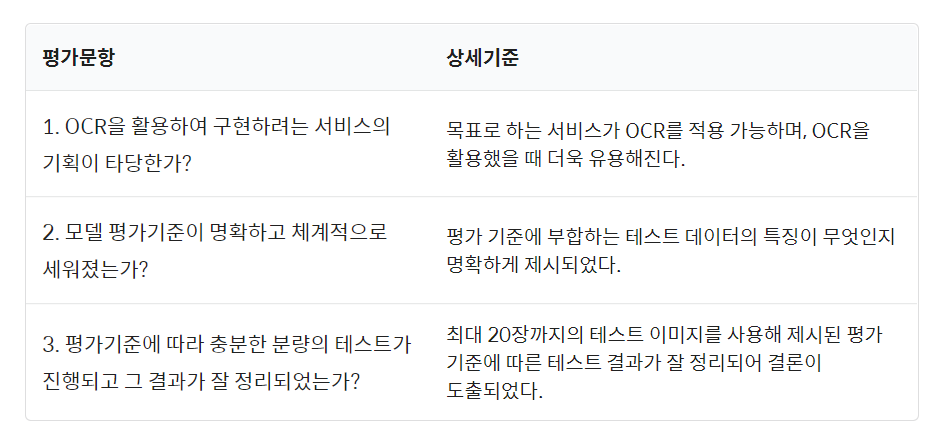

# 회고
---

- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**

 이번 프로젝트에서 제일 어려웠던 점은 tesseract 모듈 사용 시 tile cannot extend outside image 에러가 나는 이슈였다. 여러 포럼을 찾아 봤지만 해결법을 찾지 못하던 와중 동료(?)의 도움으로 이미지를 특정 사이즈로 통일 시 해당 에러가 발생하지 않는 해결법이 있었지만 사이즈를 통일 해도 에러가 해결되지 않아 에러가 발생하는 이미지 자체를 교체해서 해당 에러를 조치할 수 있었다. 왜 해당 에러가 발생하는 지는 자세히는 모르지만... 텍스트 localization 시, 해당 좌표가 이미지 사이즈를 넘어가서 발생하는 에러라고 추측하고 넘어갔다...   

또한 노드에서 제시한 keras-ocr 모듈의 출력 방법이 나머지 두 모듈과 차이가 있어 keras-ocr 모듈의 출력도 텍스트로 변환하는데 시간이 꽤 걸렸다.    

OCR 을 일상 생활이나 회사 업무시 사용해봤지만 어떻게 동작하는지 세부 로직을 알 수 있는 노드여서 재밌었던 노드였다!
